In [14]:
from Prithvi import MaskedAutoencoderViT
import torch
import yaml
import matplotlib.pyplot as plt
import numpy as np
import rasterio

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

### FUNCTIONS

In [15]:
def load_raster(path, crop=None):
    with rasterio.open(path) as src:
        img = src.read()

        # load first 6 bands
        img = img[:6]

        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb



### LOAD Prithvi

In [11]:
weights_path = "Prithvi_100M.pt"
checkpoint = torch.load(weights_path,  map_location="cpu", weights_only=True)

model_cfg_path = "Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)
    
model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

**Small input check**

Input data shape is (6, 224, 224)


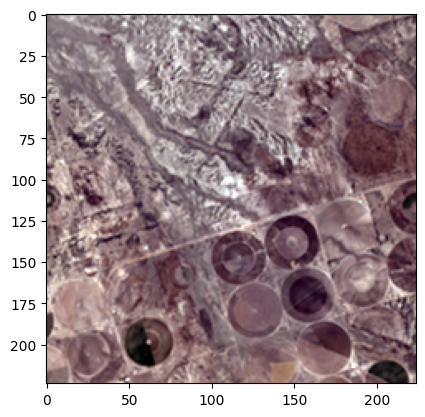

In [16]:
raster_path = "https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-demo/resolve/main/HLS.L30.T13REN.2018013T172747.v2.0.B02.B03.B04.B05.B06.B07_cropped.tif"
input_data = load_raster(raster_path, crop=(224, 224))
print(f"Input data shape is {input_data.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data)
plt.imshow(raster_for_visualization)

### Preprocess DATA & Call the MODEL

In [17]:
# statistics used to normalize images before passing to the model
means = np.array(train_args["data_mean"]).reshape(-1, 1, 1)
stds = np.array(train_args["data_std"]).reshape(-1, 1, 1)

def preprocess_image(image):
    # normalize image
    normalized = image.copy()
    normalized = ((image - means) / stds)
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    return normalized

In [18]:
normalized = preprocess_image(input_data)
with torch.no_grad():
        mask_ratio = 0.5
        _, pred, mask = model(normalized, mask_ratio=mask_ratio)
        mask_img = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])).detach().cpu()
        pred_img = model.unpatchify(pred).detach().cpu()

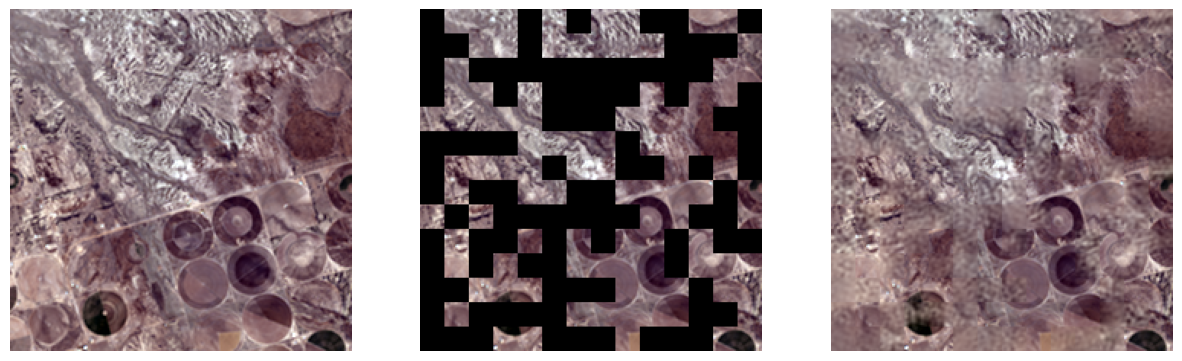

In [19]:
def plot_image_mask_reconstruction(normalized, mask_img, pred_img, stds, means):
    # Mix visible and predicted patches
    rec_img = normalized.clone()
    rec_img[mask_img == 1] = pred_img[mask_img == 1]  # binary mask: 0 is keep, 1 is remove

    mask_img_np = mask_img.numpy().reshape(6, 224, 224).transpose((1, 2, 0))[..., :3]

    rec_img_np = (rec_img.numpy().reshape(6, 224, 224) * stds) + means
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    for subplot in ax:
        subplot.axis('off')

    ax[0].imshow(enhance_raster_for_visualization(input_data))
    masked_img_np = enhance_raster_for_visualization(input_data).copy()
    masked_img_np[mask_img_np[..., 0] == 1] = 0
    ax[1].imshow(masked_img_np)
    ax[2].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=input_data))
    
plot_image_mask_reconstruction(normalized, mask_img, pred_img, stds, means)

# To do: Finetuning for our use case

- check git repository: [https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/exploration.ipynb]